In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras


## Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50


## Loading Data

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(r"C:\Users\my\Desktop\Programming\Deep Learning\potato disease\training\PlantVillage",
                                                           shuffle=True,
                                                           image_size=(
                                                               IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size=BATCH_SIZE)


Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

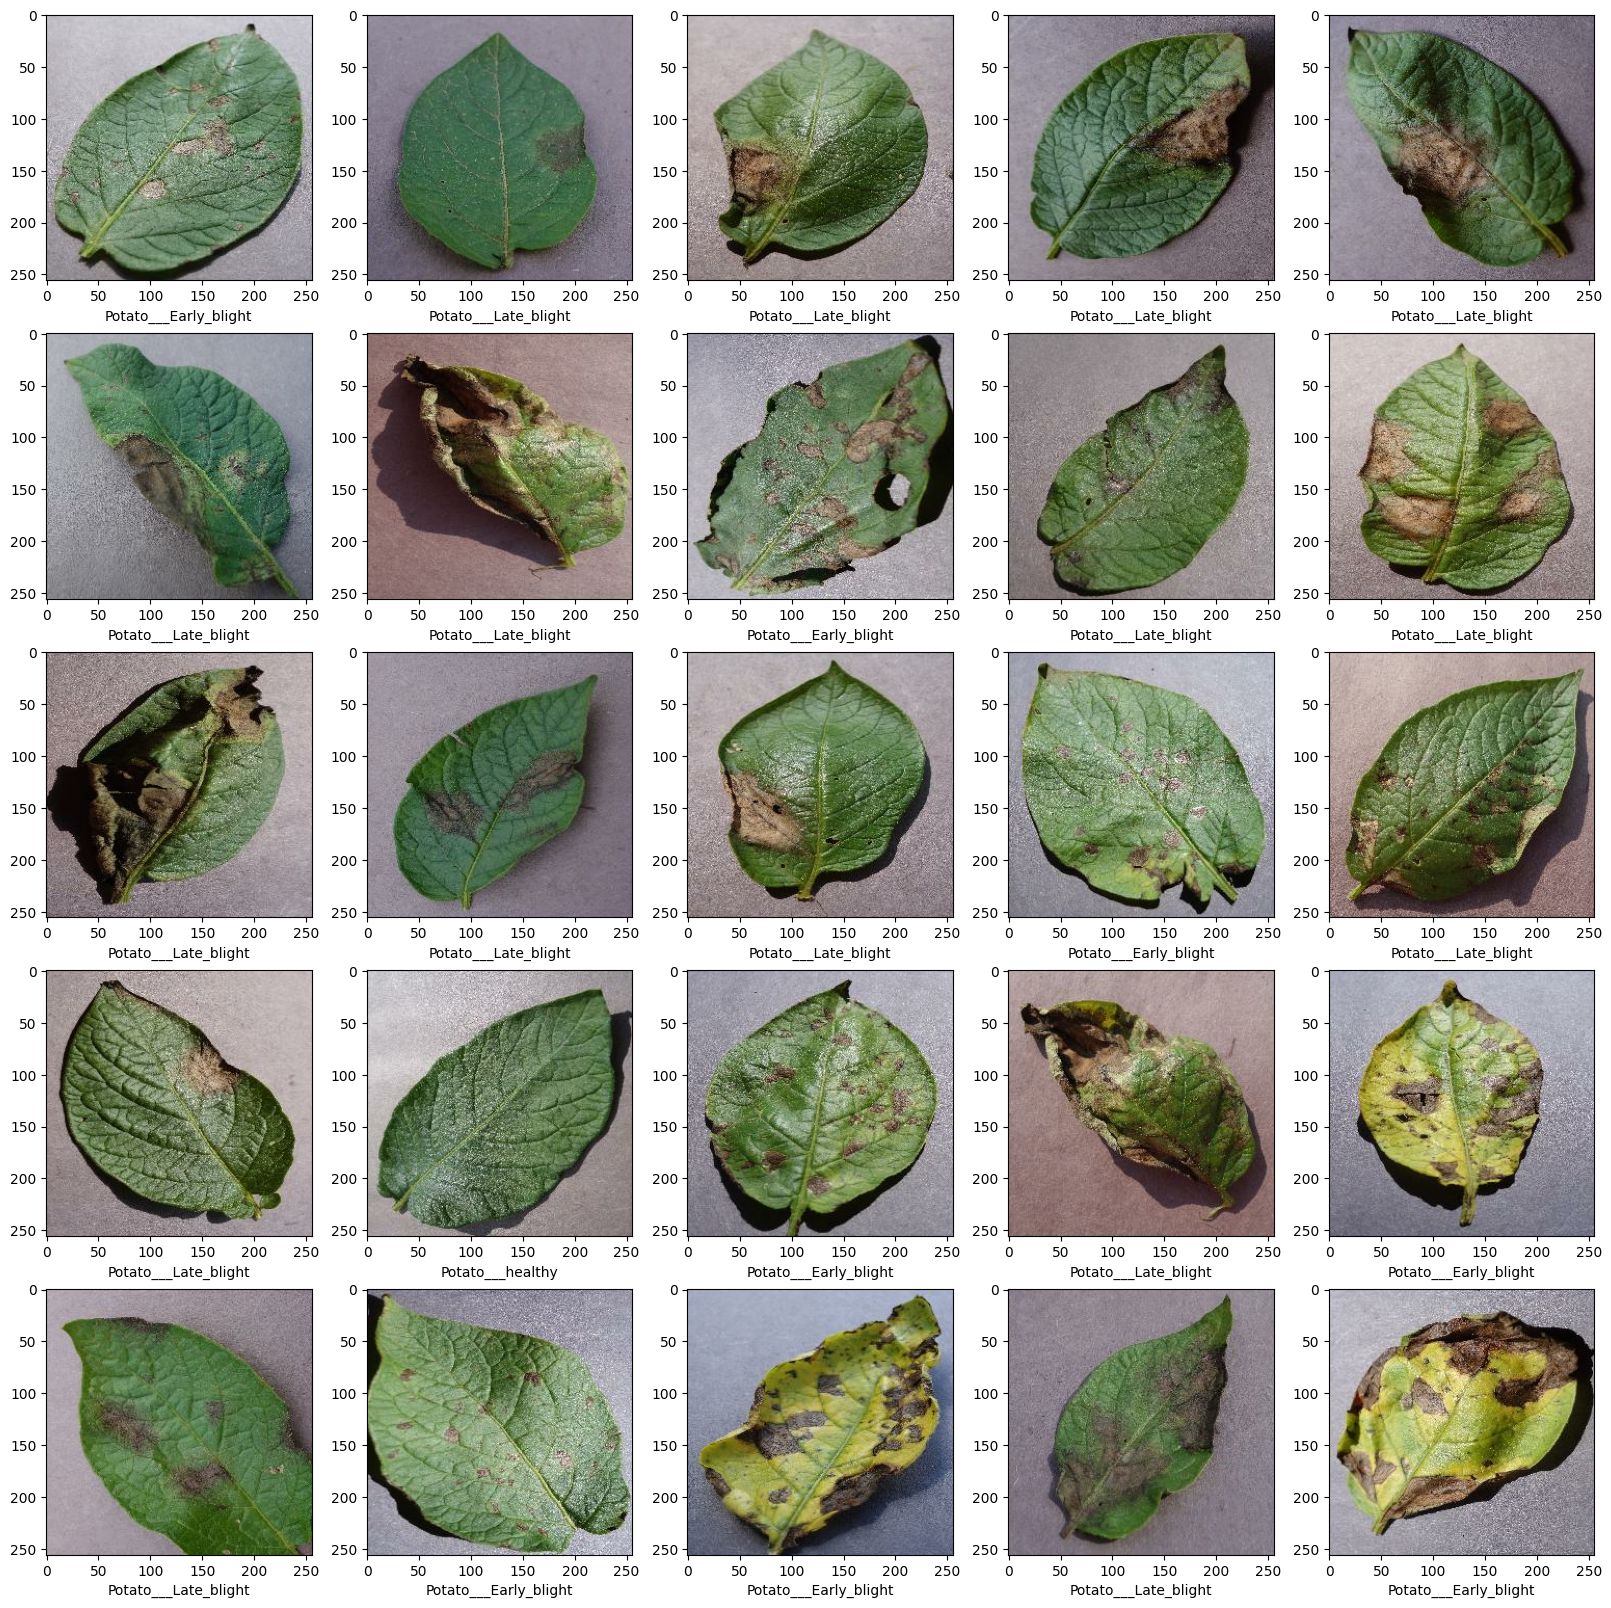

In [5]:
for image, label in dataset.take(1):
    plt.figure(figsize=(20, 20))
    i = 1
    for index in range(0, 25, 1):
        plt.subplot(5, 5, i)
        i = i+1
        plt.imshow(image[index].numpy().astype("uint8"))
        plt.xlabel(class_names[label[index]])


## Splitting Data

In [6]:
len(dataset)


68

#### We are taking 80% train, 10% validation and 10% test data, out of 68 batches

In [7]:
def get_dataset_partition(ds, train=0.8, val=0.1, test=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train*ds_size)
    val_size = int(val*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)


In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


54
6
8


## Caching data

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## Model and Data Augmentation

In [11]:
resize_and_rescale = keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1.0/255)
]) 


In [12]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
])


In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,

    # cnn
    keras.layers.Conv2D(32, (3, 3), activation="relu",
                        input_shape=input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),

    # dense
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)


In [14]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(
                  from_logits=False),
              metrics=["accuracy"])


In [16]:
history = model.fit(train_ds,
                    epochs=1,
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    validation_data=val_ds)


54/54 [==============================] - 106s 2s/step - loss: 0.9039 - accuracy: 0.5006 - val_loss: 0.8912 - val_accuracy: 0.4688


In [17]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 5s 444ms/step - loss: 1.0307 - accuracy: 0.3984


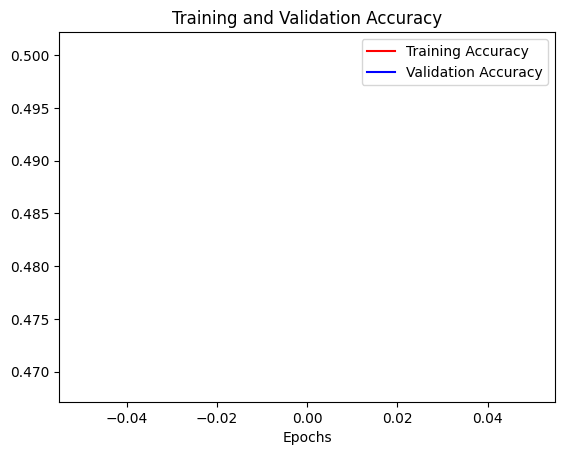

<Figure size 640x480 with 0 Axes>

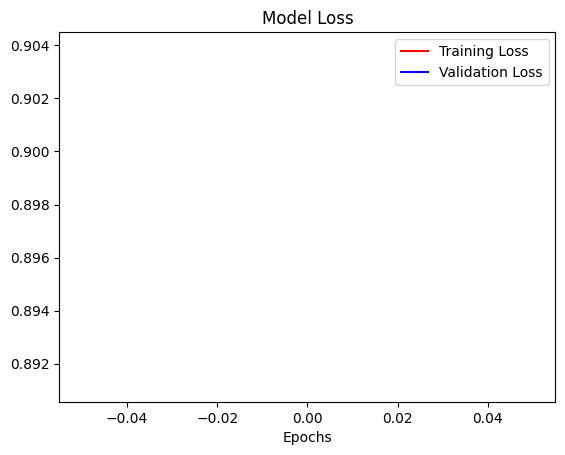

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [19]:
def predict(model, img):
    img_array = keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predict_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predict_class, confidence


1/1 [==============================] - 0s 53ms/step


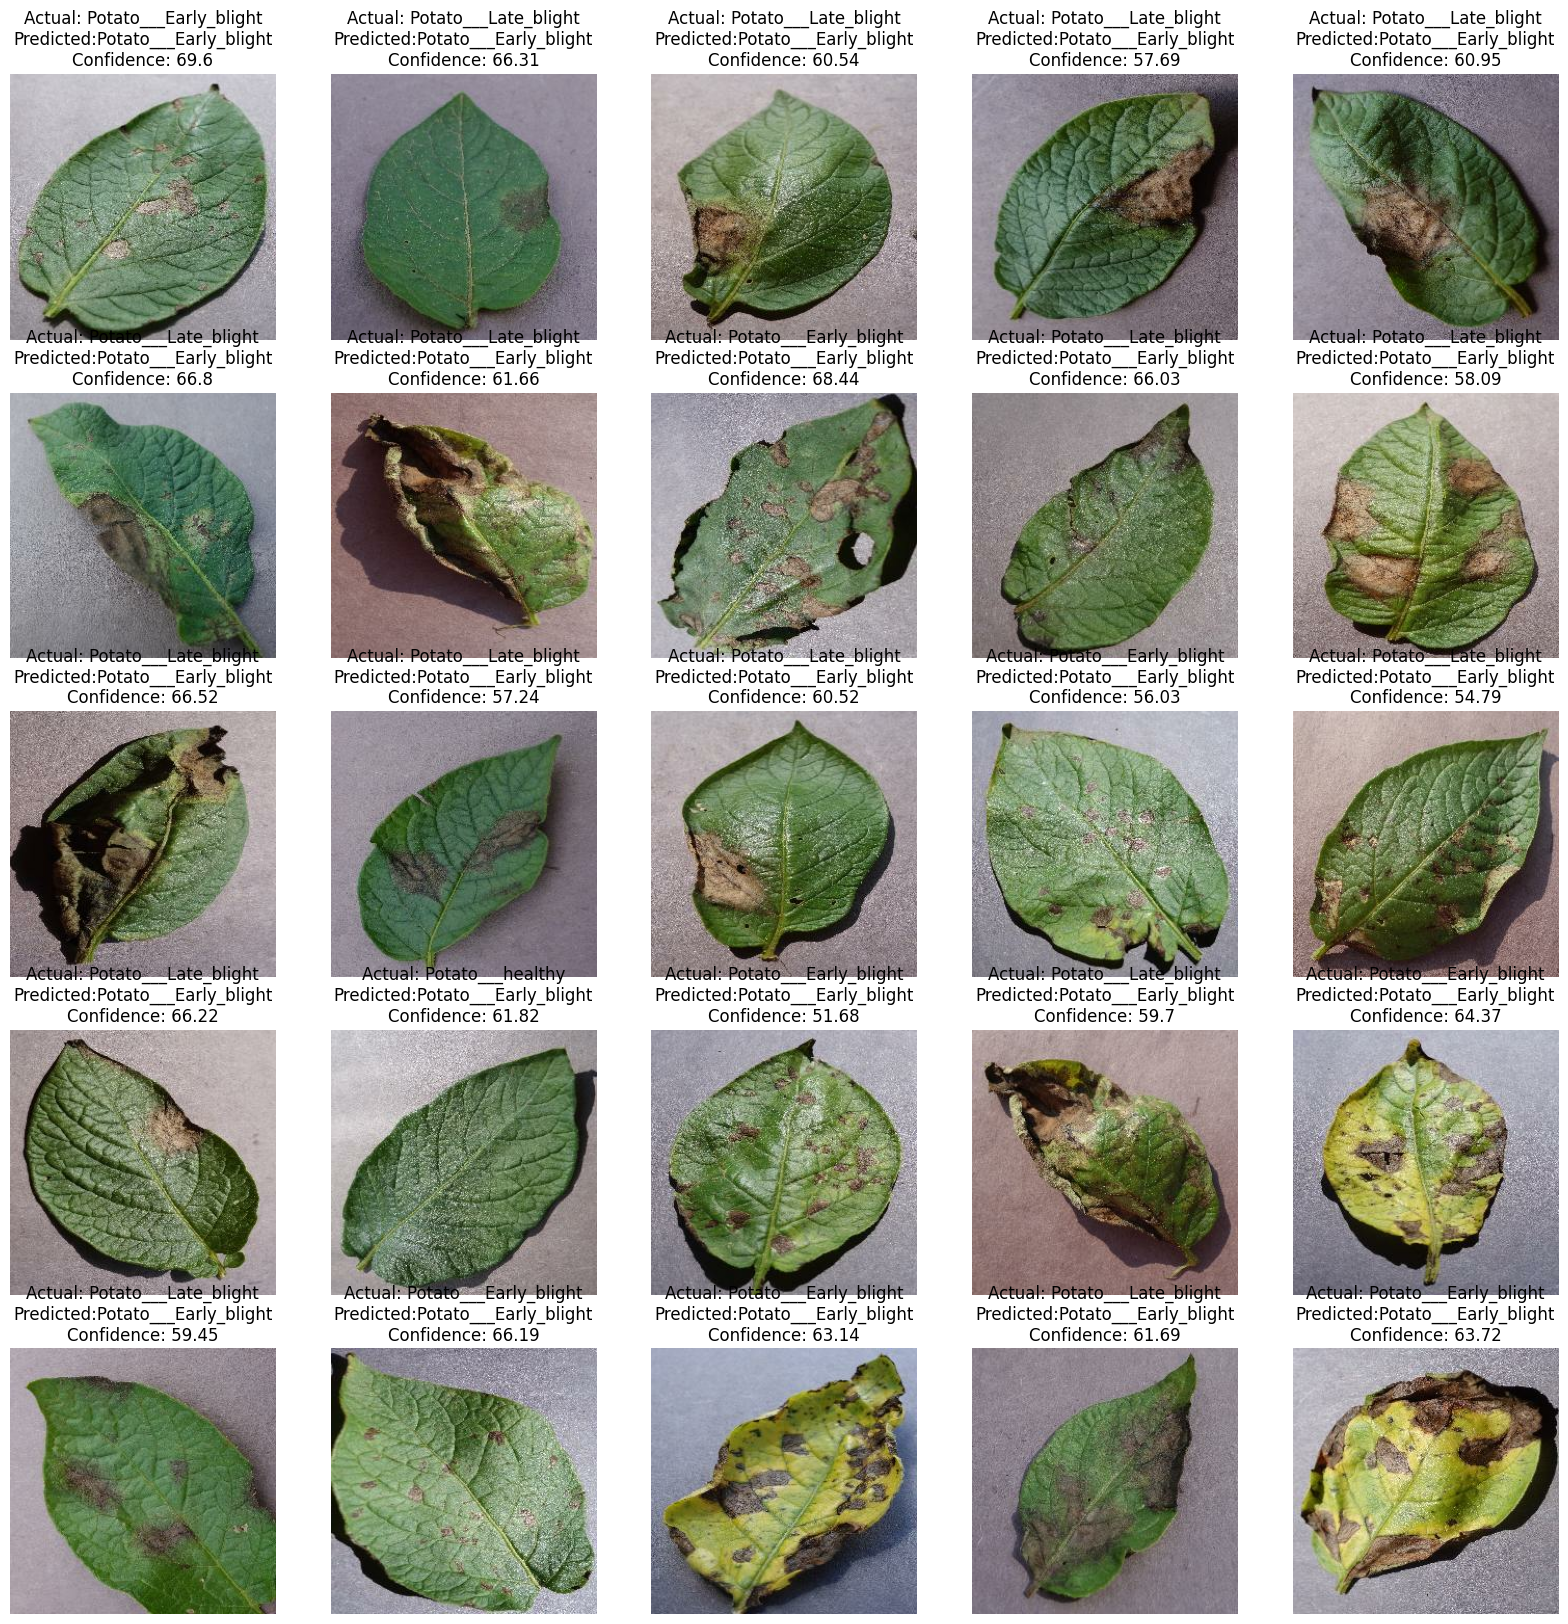

In [20]:
for images, labels in test_ds.take(1):
    plt.figure(figsize=(20, 20))
    i = 1
    for index in range(0, 25, 1):
        plt.subplot(5, 5, i)
        i = i+1
        plt.imshow(image[index].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, image[index].numpy())
        actual_class = class_names[label[index]]

        plt.title(
            f"Actual: {actual_class}\nPredicted:{predicted_class}\nConfidence: {confidence}")
        plt.axis("off")


In [21]:
model_version = 1
model.save(f"C:/Users/my/Desktop/Programming/Deep Learning/potato disease/models/{model_version}")


INFO:tensorflow:Assets written to: C:/Users/my/Desktop/Programming/Deep Learning/potato disease/models/1\assets


INFO:tensorflow:Assets written to: C:/Users/my/Desktop/Programming/Deep Learning/potato disease/models/1\assets
